#  imports

In [1]:
import pygeostat as gs
import gglib as gg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, copy, shutil, sys, glob, time
from gglib.datamgmt.simpleio import *
%matplotlib inline

In [2]:
import spatialcluster as sp

In [3]:
variables = ['Ni', 'Fe', 'SiO2', 'MgO']
nsvariables = [f'NS_{v}' for v in variables]

In [4]:
plt.rcParams['axes.titlesize'] = 10

# functions

In [5]:
sys.path.insert(0, '../')
import validator.crossval as cv
import validator.validation_utils as vf
import validator.error_functions as ef
import validator.exporter as exp
exp.init_project('nilat_')

# parameters

In [6]:
masterseed = 201904
declus_cellsize = 50
saveplots = False
rng = np.random.RandomState(masterseed)
seeds = rng.permutation(2500)[:500]
ltrim = -999
searchparams = (50, 0, 0, 800, 600, 20)
nprocesses = 6
nreal = 100

workdir = 'L:/PhD-Wrapup/Nilat/sim/'
gs.ensure_path(workdir)

In [7]:
catvarmodels = gg.load_pickle('catvarmodels.pkl')
nsvarmodels = gg.load_pickle('nsvarmodels.pkl')

In [8]:
points = gg.PointContainer('nilat_maincats.dat')

griddef = gg.GridDef(open('griddef', 'r').read())
print(griddef)

92 1879.81 10.0 
99 8953.94 10.0 
23 896.36 2.0


# clipping boundaries

In [9]:
boundct = vf.genkeyout_buffer(points, griddef, workdir, searchparams, 150)
boundct.info()

GridContainer: L:/PhD-Wrapup/Nilat/sim/nilat_maincats_keyout.dat
No Special Attributes Found 

Grid Definitions:
92 1879.81 10.0 
99 8953.94 10.0 
23 896.36 2.0

Unused Columns:
['key']


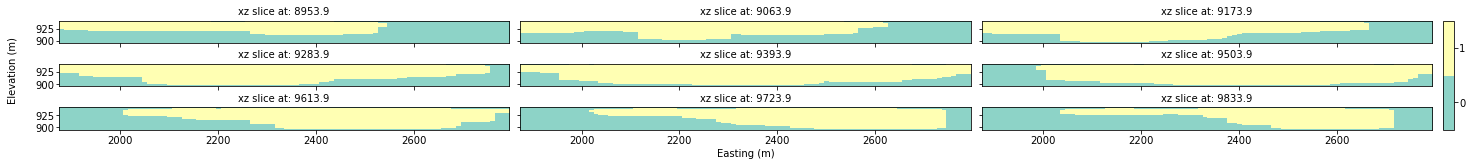

In [10]:
fig = gs.gridslicer(boundct.data, griddef, nslice=9, figsize=(25, 5), orient='xz')

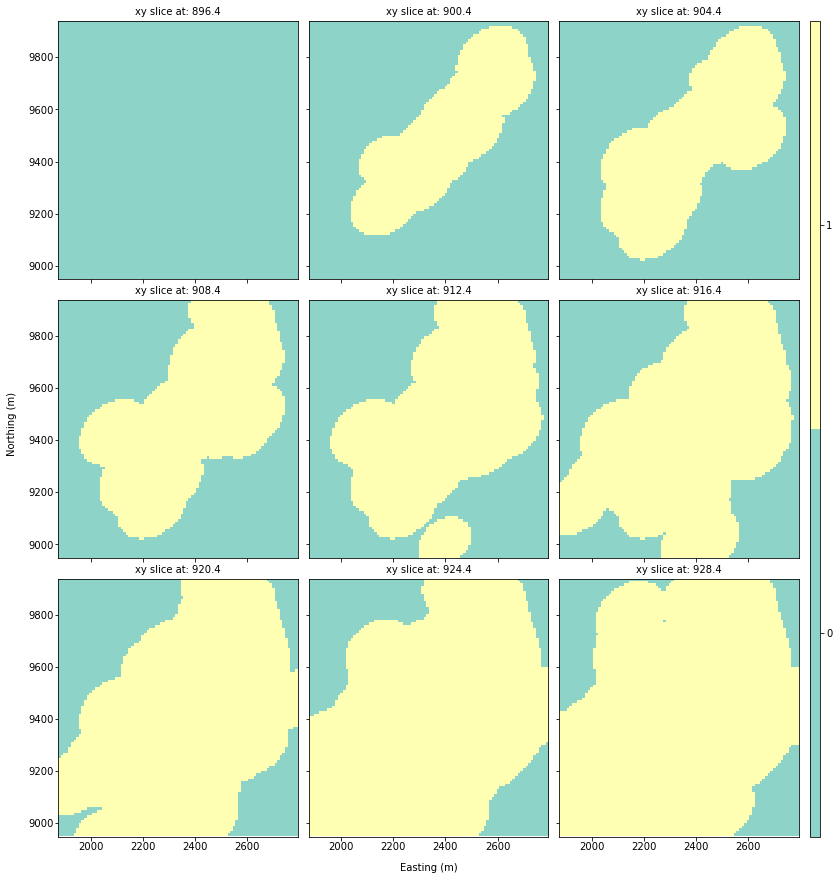

In [11]:
fig = gs.gridslicer(boundct.data, griddef, nslice=9, figsize=(15, 15), orient='xy')

# GEOSTATS
    - decluster, despike, nstransform
    - variograms, cat and continuous
    - simulation, categorical and continuous
    - backtransform and post-processings
    - validation stuff

# iterate through decisions of stationarity and generate the final models

In [14]:
t1 = time.time()
iseed = 0
catcols = ['modelcats', 'mvclus', 'betteragglom']
for iseed, (catcol) in gg.log_enum(catcols):
    dtime = time.time()
    ### RUN CROSSVAL
    try:
        cv.domainfold(
            -1, catcol, workdir, points, None, boundct, griddef, variables, 
            catvarmodels, nsvarmodels, declus_cellsize,
            seeds[iseed], ltrim, nreal, searchparams, 
            nprocesses, saveplots=False, trenddist=500
        )
    except Exception as e:
        raise
    finally:
        print(f'Finished {catcol}\n'
              f'  elapsed:  {(time.time()-dtime)/60:.4f} min\n'
              f'  total elapsed: {(time.time()-t1)/60:.4f} min')
    plt.close()
    import gc; gc.collect()
print('Finished in {:.4f} hours'.format((time.time() - t1) / 3600))

Finished mvclus
  elapsed:  6.4426 min
  total elapsed: 6.4428 min

Finished in 0.1074 hours


# multi-cats

In [13]:
t1 = time.time()
iseed = 0

catcols = [f'clusreal{i}' for i in range(nreal)]           
catbase = 'reals_ensbest'

dtime = time.time()
### RUN CROSSVAL
try:
    cv.domainfold_multi(
        -1, catbase, catcols, workdir, points, None, boundct, griddef, variables, 
        catvarmodels, nsvarmodels, declus_cellsize,
        seeds[iseed], ltrim, nreal, searchparams, nprocesses, saveplots=False, 
        trenddist=500
    )
except Exception as e:
    raise
finally:
    print(f'Finished {catcol}\n'
          f'  elapsed:  {(time.time()-dtime)/60:.4f} min\n'
          f'  total elapsed: {(time.time()-t1)/60:.4f} min')
plt.close()
import gc; gc.collect()
print('Finished in {:.4f} hours'.format((time.time() - t1) / 3600))

Finished betteragglom
  elapsed:  7.1779 min
  total elapsed: 7.1779 min
Finished in 0.1196 hours
